#### Post-processing notebook

This notebook only works with already exported results (via inference.py script). No online inference from a checkpoint
is done here.

In [37]:
from pathlib import Path
from PIL import Image
from vre.utils import colorize_semantic_segmentation, lo, collage_fn, image_resize, image_add_title
import numpy as np
from torchmetrics.functional.classification import multiclass_stat_scores 
import torch as tr
import random

from postproc import apply_pos, apply_neg, apply_postproc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
pred_dir = Path("../results/m3_ens10")
pred0_dir = Path("../results/m3")
gt_dir = Path("../../../datasets/dronescapes-2024/data/test_set_annotated_only")

In [39]:
color_map_8 = [[0, 255, 0], [0, 127, 0], [255, 255, 0], [255, 255, 255],
               [255, 0, 0], [0, 0, 255], [0, 255, 255], [127, 127, 63]]
classes_8 = ["land", "forest", "residential", "road", "little-objects", "water", "sky", "hill"]

color_map_2 = [[0, 0, 0], [255, 255, 255]]

def color_sema(x: np.ndarray) -> np.ndarray:
    assert x.shape[-1] == 8 and len(x.shape) == 3, x.shape
    return colorize_semantic_segmentation(x.argmax(-1).astype(np.uint8)[None], classes_8, color_map_8, size_px=30)[0]

def color_bw(x: np.ndarray) -> Image:
    assert len(x.shape) == 2, x.shape
    return np.array(color_map_2)[(x >= 0.5).astype(np.uint8)].astype(np.uint8)

def load(x, gt: bool=False, rgb: bool=False):
    res = np.load(x)["arr_0"]
    if rgb:
        assert res.dtype == np.uint8
        return res
    return np.eye(8)[res].astype(np.uint8) if gt else res

def iou(pred: np.ndarray, gt: np.ndarray) -> float:
    assert pred.shape[-1] == 8 and gt.shape[-1] == 8
    pred_argmax, gt_argmax = pred.argmax(-1), gt.argmax(-1)
    tp, fp, _, fn = multiclass_stat_scores(tr.from_numpy(pred_argmax), tr.from_numpy(gt_argmax),
                                           num_classes=8, average=None)[:, 0:4].T
    iou = tp / (tp + fp + fn)
    w = tr.FloatTensor([0.28172092, 0.30589653, 0.13341699, 0.05937348, 0.00474491, 0.05987466, 0.08660721, 0.06836531])
    return round((iou.nan_to_num(0, 0, 0) * w).sum().item(), 3)

def apply_both(sema: np.ndarray, binary_map: np.ndarray, mapped_list: list[str]) -> np.ndarray:
    return apply_neg(apply_pos(sema, binary_map, mapped_list), binary_map, mapped_list)


#### Apply the post-processing steps

Take a random prediction (stored offline) from both pred-0 and pred-ens and apply the post-processing steps.
Measure the IoU at each step.

comana_DJI_0881_full_8040.npz
(540, 960) (540, 960) (540, 960) (540, 960) (540, 960) (540, 960) (540, 960, 8) (540, 960, 8) (540, 960, 8) (540, 960, 3)


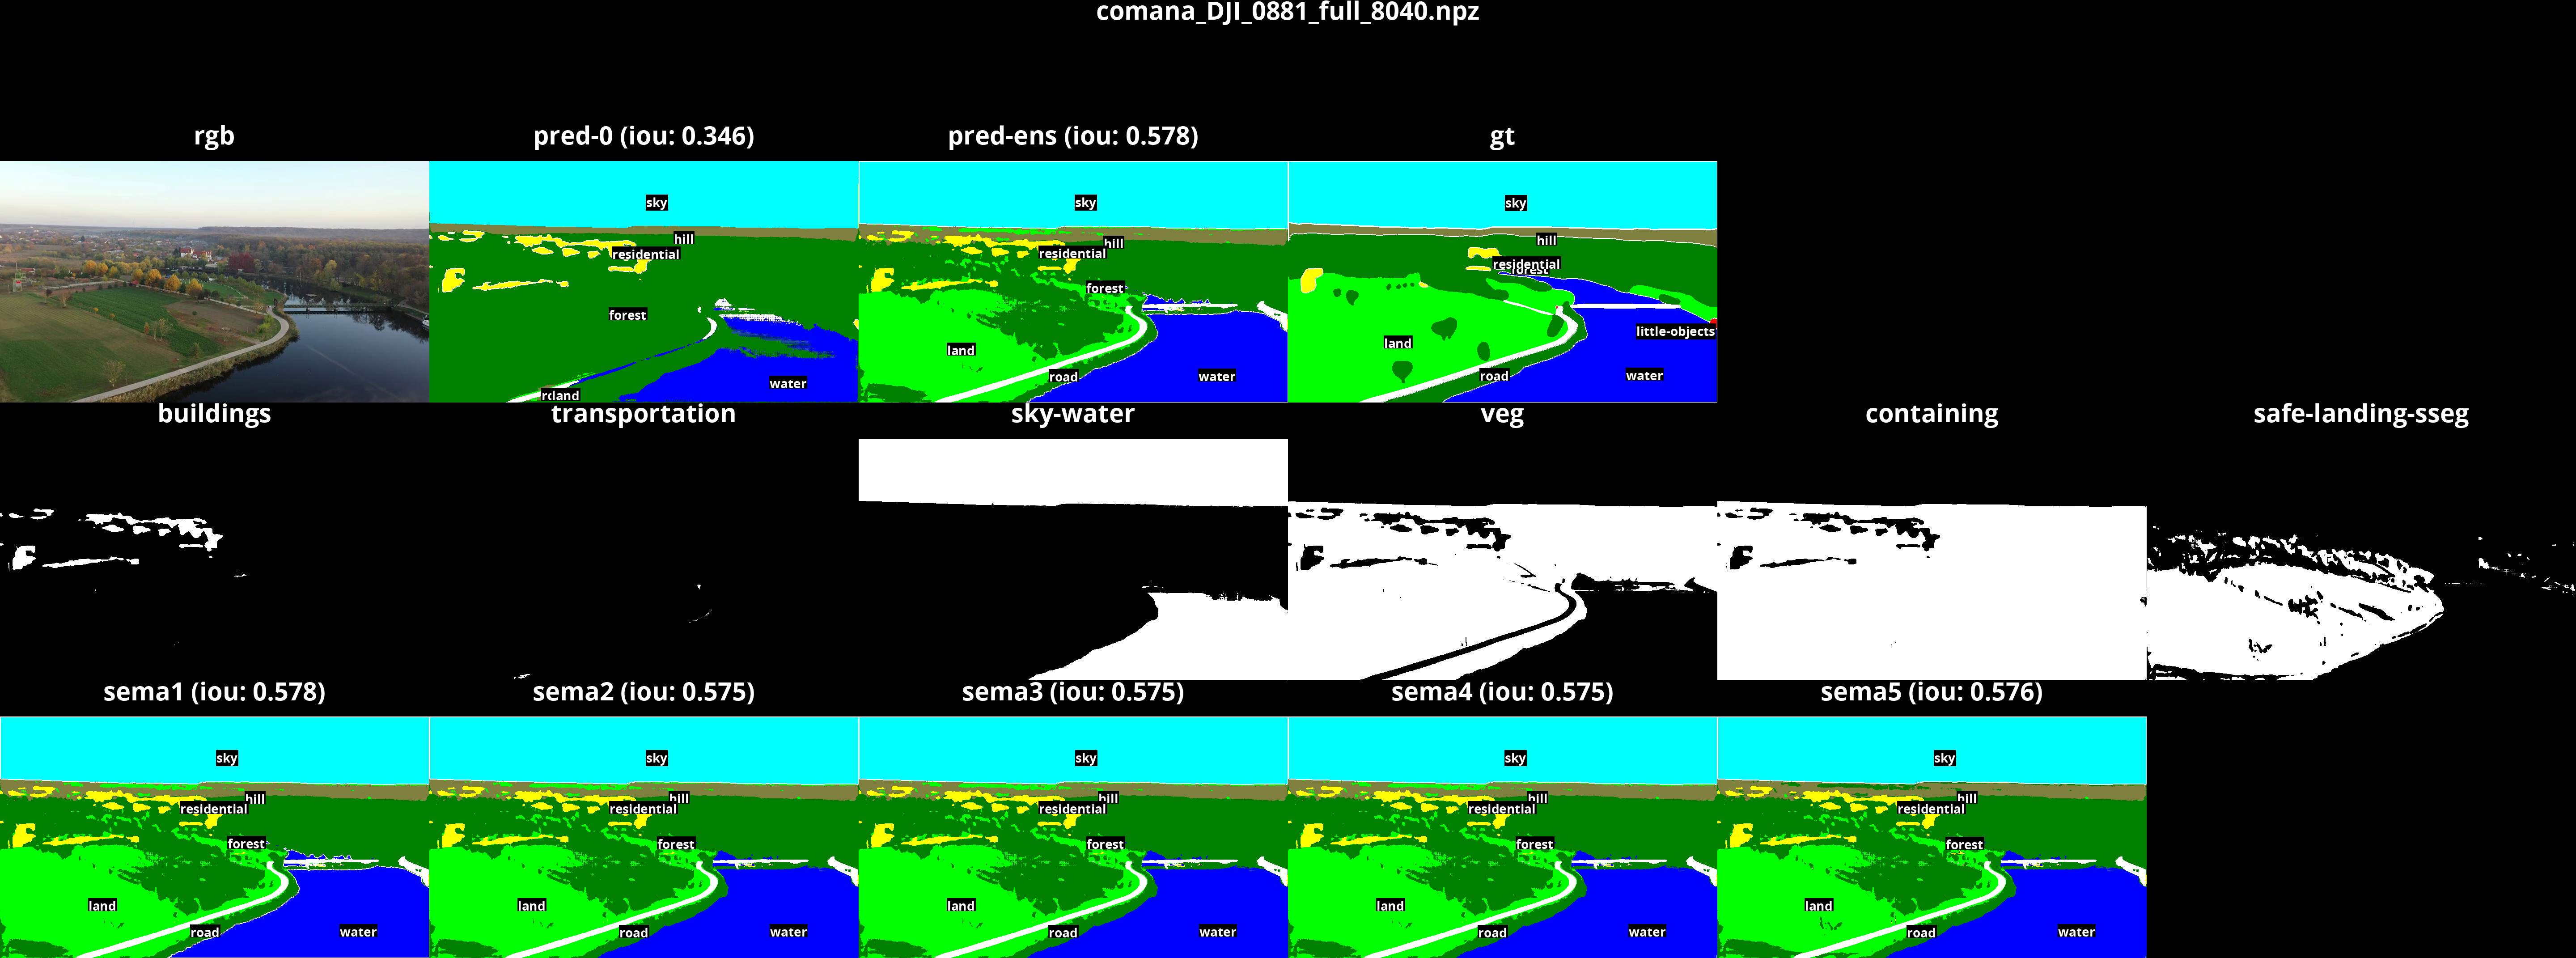

In [40]:
buildings_dir = (pred_dir / "buildings")
sky_water_dir = (pred_dir / "sky-and-water")
vegetation_dir = (pred_dir / "vegetation")
transportation_dir = (pred_dir / "transportation")
containing_dir = (pred_dir / "containing")
safe_landing_dir = pred_dir / "safe-landing-semantics"
sema_dir = (pred_dir / "semantic_segprop8")
sema0_dir = (pred0_dir / "semantic_segprop8")
gt_sema_dir = gt_dir / "semantic_segprop8"
gt_rgb_dir = gt_dir / "rgb"

# while True:
names = list(sema_dir.iterdir())
rand_name = random.choice(range(len(names)))
name = names[rand_name].name
# name = "comana_DJI_0881_full_6180.npz"
# if name.find("comana") == -1:
#     continue
print(name)
dirs = [buildings_dir, sky_water_dir, vegetation_dir, transportation_dir, containing_dir,
        safe_landing_dir, sema_dir, sema0_dir, gt_sema_dir, gt_rgb_dir]
y = [load(x / name).squeeze() for x in dirs[0:-2]] + [load(gt_sema_dir / name, gt=True),
                                                        load(gt_rgb_dir / name, rgb=True)]
b, sw, veg, t, c, sls, sema, sema0, gt_sema, gt_rgb = y
print(b.shape, sw.shape, veg.shape, t.shape, c.shape, sls.shape, sema.shape, sema0.shape, gt_sema.shape, gt_rgb.shape)

iou0, iou_ens = iou(sema0, gt_sema), iou(sema, gt_sema)
titles = ["rgb", f"pred-0 (iou: {iou0})", f"pred-ens (iou: {iou_ens})", "gt", "", "", "buildings", "vegetation",
        "sky-water", "transportation", "containing", "safe-landing-semantics"]
Y = collage_fn([gt_rgb, color_sema(sema0), color_sema(sema), color_sema(gt_sema), color_bw(b*0), color_bw(b*0),
                color_bw(b), color_bw(veg), color_bw(sw), color_bw(t), color_bw(c), color_bw(sls)],
                titles=titles, size_px=55, rows_cols=(2, -1))
# Y = image_resize(Y, width=1300, height=None)
# display(Image.fromarray(Y))

sema1, sema2, sema3, sema4, sema5 = apply_postproc(sema, b, veg, t, sw, sls, c, classes=classes_8, return_all=True)
pred_iou = iou(sema, gt_sema)
pred0_iou = iou(sema0, gt_sema)

preds = [sema1, sema2, sema3, sema4, sema5]
ious = [iou(_sema, gt_sema) for _sema in preds]
titles = ["rgb", f"pred-0 (iou: {pred0_iou})", f"pred-ens (iou: {pred_iou})", "gt", *([""] * (len(y) - 8)),
        "buildings", "transportation", "sky-water", "veg", "containing", "safe-landing-sseg"]
imgs = [gt_rgb, color_sema(sema0), color_sema(sema), color_sema(gt_sema), *([color_bw(b) * 0] * (len(y) - 8)),
        color_bw(b), color_bw(t), color_bw(sw), color_bw(veg), color_bw(c), color_bw(sls)]
for i, (_iou, _pred) in enumerate(zip(ious, preds)):
    titles.append(f"sema{i+1} (iou: {_iou})")
    imgs.append(color_sema(_pred))

diff = abs(pred_iou - ious[-1])
# if diff > 0.01 and iou_ens > iou0:
collage = image_add_title(collage_fn(imgs, titles=titles, size_px=50, rows_cols=(3, -1)), name, size_px=50)
display(Image.fromarray(collage))
# break
